In [12]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats

FILE_PATH = '/content/Metrics Dataset - Sheet15 - Metrics Dataset - Sheet15.csv'
CONF = 0.95
TARGET = None

df = pd.read_csv(FILE_PATH)
print(df.shape)
print(df.dtypes)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(num_cols)
if TARGET is None:
    TARGET = num_cols[0]
x = pd.to_numeric(df[TARGET], errors='coerce').dropna().values.astype(float)
N = x.size
print(TARGET, N)

(2856, 4)
Sl. No.                 int64
Metric Name            object
Definition             object
Preferred Direction    object
dtype: object
['Sl. No.']
Sl. No. 2856


In [13]:
N = x.size
x_mean = x.mean()
x_var = x.var(ddof=1)
x_std = np.sqrt(x_var)
print(N, x_mean, x_var, x_std)

2856 1428.5 679966.0 824.6005093377034


In [14]:
bins = int(1 + 3.322 * np.log10(N))
hist, edges = np.histogram(x, bins=bins)
from scipy.stats import norm
cdf = norm.cdf
p = cdf((edges[1:]-x_mean)/x_std) - cdf((edges[:-1]-x_mean)/x_std)
exp = N * p
mask = exp > 0
chi2 = (((hist[mask]-exp[mask])**2)/exp[mask]).sum()
df_chi = mask.sum() - 3
p_chi = 1 - stats.chi2.cdf(chi2, df_chi) if df_chi>0 else np.nan

dago_stat, dago_p = stats.normaltest(x) if N>=8 else (np.nan, np.nan)
ks_stat, ks_p = stats.kstest((x - x_mean)/x_std, 'norm')

print(chi2, df_chi, p_chi)
print(dago_stat, dago_p)
print(ks_stat, ks_p)

662.3206421938204 9 0.0
2361.7129924317137 0.0
0.057341122687247004 1.3260415164660233e-08


In [15]:
alpha = 1 - CONF
t_q = stats.t.ppf(1 - alpha/2, df=N-1)
mean_ci = (x_mean - t_q * x_std/np.sqrt(N), x_mean + t_q * x_std/np.sqrt(N))

chi_low = stats.chi2.ppf(alpha/2, df=N-1)
chi_high = stats.chi2.ppf(1 - alpha/2, df=N-1)
std_ci = (np.sqrt((N-1)*x_var/chi_high), np.sqrt((N-1)*x_var/chi_low))

print(mean_ci)
print(std_ci)

(np.float64(1398.2450288509135), np.float64(1458.7549711490865))
(np.float64(803.7578354782315), np.float64(846.5609317922306))


In [16]:
G = np.max(np.abs(x - x_mean)) / x_std
t_crit = stats.t.ppf(1 - alpha/(2*N), df=N-2)
G_crit = ((N-1)/np.sqrt(N)) * np.sqrt(t_crit**2 / (N-2 + t_crit**2))
is_outlier = G > G_crit

print(G, G_crit, bool(is_outlier))
if is_outlier:
    idx = np.argmax(np.abs(x - x_mean))
    x2 = np.delete(x, idx)
    N2 = x2.size
    x2_mean = x2.mean()
    x2_var = x2.var(ddof=1)
    x2_std = np.sqrt(x2_var)
    t_q2 = stats.t.ppf(1 - alpha/2, df=N2-1)
    mean_ci2 = (x2_mean - t_q2 * x2_std/np.sqrt(N2), x2_mean + t_q2 * x2_std/np.sqrt(N2))
    chi_low2 = stats.chi2.ppf(alpha/2, df=N2-1)
    chi_high2 = stats.chi2.ppf(1 - alpha/2, df=N2-1)
    std_ci2 = (np.sqrt((N2-1)*x2_var/chi_high2), np.sqrt((N2-1)*x2_var/chi_low2))
    print(idx, x[idx], x2_mean, x2_std, mean_ci2, std_ci2)

1.731141302770391 4.287967951972899 False


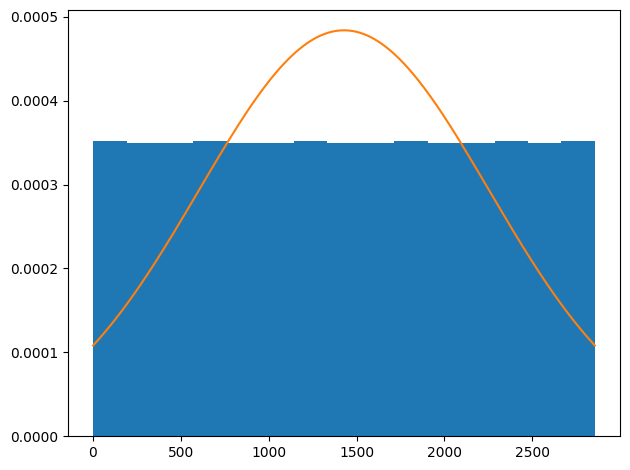

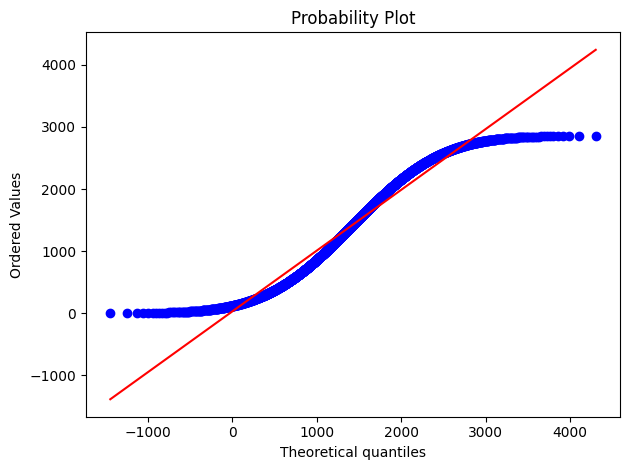

In [17]:
plt.figure()
plt.hist(x, bins='auto', density=True)
grid = np.linspace(x.min(), x.max(), 400)
from scipy.stats import norm
pdf = norm.pdf(grid, loc=x_mean, scale=x_std)
plt.plot(grid, pdf)
plt.tight_layout()
plt.show()

plt.figure()
stats.probplot(x, dist="norm", sparams=(x_mean, x_std), plot=plt)
plt.tight_layout()
plt.show()